### Exploration of the DailyDialog dataset.
Link: http://yanran.li/dailydialog | Paper: https://arxiv.org/pdf/1710.03957.pdf

~ 13,000 multi-turn (more than a single utterance) dialogs, human-labelled and cross-verified for:
- BROAD topic (e.g. "leisure" vs "politics")
- Emotion ({ 0: no emotion, 1: anger, 2: disgust, 3: fear, 4: happiness, 5: sadness, 6: surprise})
- Action type ({ 1: inform，2: question, 3: directive, 4: commissive })

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import pytextrank
%matplotlib inline
import spacy
plt.style.use('ggplot')
from spacy import displacy
import numpy as np
import itertools
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = stopwords.words('english')

In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
with open('../data/dialogues_text.txt') as file:
    dialogs = [line.rstrip('\n') for line in file]

In [4]:
with open('../data/dialogues_emotion.txt') as file:
    emotions = [line.rstrip('\n') for line in file]

In [69]:
emotions_sp = [list(map(int, emo.split())) for emo in emotions]
# 672 has incomplete emotion data!
emotions_sp[672].append(0)

In [11]:
dialogs_sp = [line.split("__eou__")[:-1] for line in dialogs]

In [70]:
all_emotions = list(itertools.chain.from_iterable(emotions_sp))

In [71]:
count_dict = {}
for emote_list in emotions_sp:
    for emote in emote_list:
        try:
            count_dict[emote]+=1
        except:
            count_dict[emote]=0
count_arr = [count_dict[k] for k in sorted(count_dict.keys())]

Text(0.5,0,'Emotion Label')

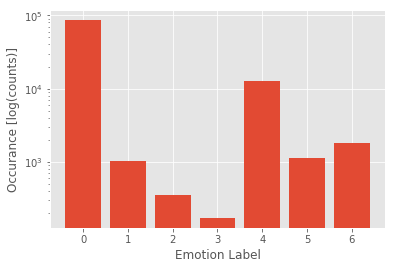

In [72]:
f,ax = plt.subplots()
ax.bar(range(7),count_arr)
ax.set_yscale('log')
ax.set_ylabel('Occurance [log(counts)]')
ax.set_xlabel('Emotion Label')

In [62]:
dialogs_lens = [len(dlg) for dlg in dialogs_sp]
emotions_lens = [len(emote) for emote in emotions_sp]
check_data = [dialogs_lens[i] == emotions_lens[i] for i in range(len(emotions_lens))]

In [64]:
check_data.index(False)

672

In [75]:
# Emotion ({ 0: no emotion, 1: anger, 2: disgust, 3: fear, 4: happiness, 5: sadness, 6: surprise})
all_utterances =  list(itertools.chain.from_iterable(dialogs_sp))
anger_utterances = [dlg for i,dlg in enumerate(all_utterances) if all_emotions[i]==1]
disgust_utterances = [dlg for i,dlg in enumerate(all_utterances) if all_emotions[i]==2]
fear_utterances = [dlg for i,dlg in enumerate(all_utterances) if all_emotions[i]==3]
happy_utterances = [dlg for i,dlg in enumerate(all_utterances) if all_emotions[i]==4]
sad_utterances = [dlg for i,dlg in enumerate(all_utterances) if all_emotions[i]==5]
surprise_utterances = [dlg for i,dlg in enumerate(all_utterances) if all_emotions[i]==6]

In [121]:
all_emotive_utterances = [dlg for i,dlg in enumerate(all_utterances) if not all_emotions[i]==0]

In [122]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
all_emotive_utterances_no_punct = [regex.sub('',utt).lower().strip() for utt in all_emotive_utterances]

In [111]:
all_utterances_no_punct_nostops = [' '.join([word for word in utt.split() if word not in stop_words]) for utt in all_utterances_no_punct]

In [130]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
vader_all_utterances_nopunct_nostops = [sid.polarity_scores(utt) for utt in all_utterances_no_punct_nostops]

In [132]:
emote_df = pd.DataFrame(vader_all_utterances_nopunct_nostops)

In [153]:
emote_df['dailydialog_label'] = all_emotions
emote_df['dailydialog_label_color'] = emote_df['dailydialog_label'].map({0:'white',1:'red',
                                                                         2:'green',3:'yellow',
                                                                         4:'pink',5:'blue',6:'orange'})
emote_df['dailydialog_label_alpha'] = emote_df['dailydialog_label'].map({0:0.05,1:0.1,
                                                                         2:0.1,3:0.1,
                                                                         4:0.1,5:0.1,
                                                                         6:0.1})

Text(0,0.5,'Positivity VADER Score')

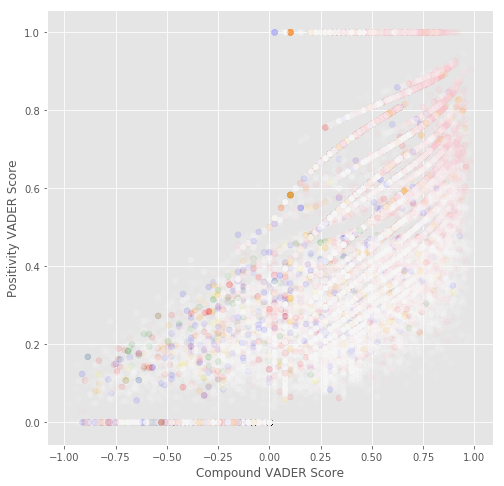

In [165]:
f,ax = plt.subplots(figsize=(8,8))
ax.scatter(emote_df['compound'],emote_df['pos'],c=emote_df['dailydialog_label_color'],alpha=0.1)
ax.set_xlabel('Compound VADER Score')
ax.set_ylabel('Positivity VADER Score')

In [126]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans

corpus = all_emotive_utterances_no_punct
labels = [emo for emo in all_emotions if emo!=0] #all emotions
true_k = len(set(labels))

vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000, stop_words='english', use_idf=True)
X = vectorizer.fit_transform(corpus)
print("Performing dimensionality reduction using LSA")
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_lsa = lsa.fit_transform(X)
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
print()
print('Begin kmeans')
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,verbose=False)
km.fit(X_lsa)

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 37%

Begin kmeans


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=6, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)

In [127]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.032
Completeness: 0.039
V-measure: 0.035
Adjusted Rand-Index: -0.091
Silhouette Coefficient: 0.016


In [129]:
print("Top terms per cluster:")
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: good idea sounds thats luck really like pretty night time
Cluster 1: thank really like oh im great yes just thats nice
Cluster 2: dont mention know worry think im like want really just
Cluster 3: thanks lot help ill great ok im oh thats fine
Cluster 4: think like good really great ill don im yes thats
Cluster 5: beautiful look really oh enjoy new wow view yes isnt


In [76]:
dialog_num_turns = [len(dlg) for dlg in dialogs_sp]

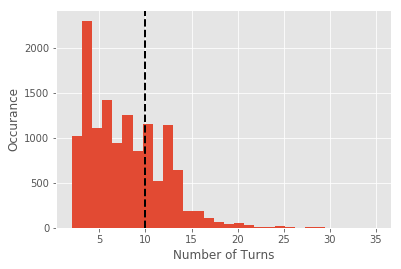

In [77]:
plt.style.use('fast')
plt.hist(dialog_num_turns,bins=30)
plt.xlabel('Number of Turns')
plt.ylabel('Occurance')
plt.axvline(10,c='k',lw=2,ls='--')

In [78]:
dialogs_with_more_than_10_turns = [dlg for i,dlg in enumerate(dialogs) if dialog_num_turns[i]>10]

In [79]:
len(dialogs_with_more_than_10_turns)

3061

In [80]:
nlpd_longer_dialogs = [nlp(dlg.replace("__eou__","")) for dlg in dialogs_with_more_than_10_turns]

KeyboardInterrupt: 

In [173]:
dialogs_with_more_than_10_turns[5]

"Peter , where are you going ? __eou__ I'm going to do some shopping . __eou__ Won't you watch TV ? __eou__ What's on TV tonight ? Is there a football match ? __eou__ The TV station will air the World Cup football match alive at 8: 30 . __eou__ Really ? Who will play ? __eou__ The Brazilian team versus the American team . Don't miss it . __eou__ That's cool . I'll watch it . __eou__ Who do you think will win ? __eou__ There is no doubt that the Brazilian team will win . __eou__ I think so . __eou__"

In [37]:
ents_longer_dialogs = [dlg.ents for dlg in nlpd_longer_dialogs]

In [155]:
num_ents_longer_dialogs = [len(entlist) for entlist in ents_longer_dialogs]

Text(0.5,1,'Entities: Persons, Nationalities, Organizations, etc.')

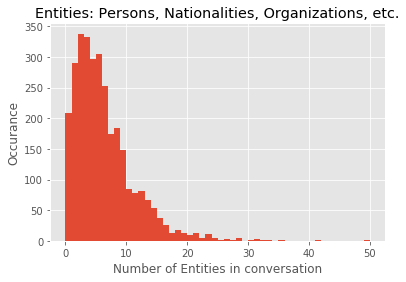

In [160]:
plt.hist(num_ents_longer_dialogs,bins=50)
plt.xlabel('Number of Entities in conversation')
plt.ylabel('Occurance')
plt.title('Entities: Persons, Nationalities, Organizations, etc.')

In [58]:
displacy.render(nlpd_longer_dialogs[5],jupyter=True,style='ent')

In [92]:
for dc in nlpd_longer_dialogs[:10]:
    for ent in dc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    print('='*5)

Laura 394 399 PERSON
Carmen 604 610 PERSON
=====
Cambridge University 18 38 ORG
some years ago 265 279 DATE
afternoon 410 419 TIME
Mrs 422 425 PERSON
Smith 428 433 PERSON
=====
Wangfujing 32 42 GPE
Winner 218 224 PERSON
English 227 234 LANGUAGE
the Beijing Olympic Games 256 281 EVENT
English 327 334 LANGUAGE
96.6 353 357 CARDINAL
China Business Radio 360 380 ORG
English 437 444 LANGUAGE
6:40 every morning 561 579 TIME
20 minutes 598 608 TIME
=====
everyday 148 156 DATE
50 Yuan per month 724 741 QUANTITY
=====
Channel 5 244 253 ORG
Channel 5 274 283 ORG
today 373 378 DATE
today 404 409 DATE
Chinese 440 447 NORP
American 457 465 NORP
=====
Peter 0 5 PERSON
tonight 99 106 TIME
World Cup 166 175 EVENT
8 200 201 CARDINAL
30 203 205 CARDINAL
Brazilian 239 248 NORP
American 265 273 NORP
Brazilian 385 394 NORP
=====
Helen 21 26 PERSON
=====
60 221 223 CARDINAL
next Friday 233 244 DATE
100 412 415 MONEY
80 514 516 MONEY
=====
one 271 274 CARDINAL
=====
6 yuan 170 176 MONEY
4 yuan 270 276 MONEY


In [146]:
from gensim.summarization import keywords #TextRank keywords
from gensim.summarization.summarizer import summarize #TextRank
#from gensim.summarization.textcleaner import clean_text_by_word, clean_text_by_sentences
from spacy.matcher import Matcher

In [136]:
dc = nlpd_longer_dialogs[0]
print(keywords(dc.text,lemmatize=True).split('\n'))
print(summarize(dc.text))

['falling', 'like', 'faultless performance', 'thing']
You know , I couldn't help falling asleep .
Then I doubt if you like operas at all .
And I do like the leading actress who has an amazing voice .
There was always a good round of applause every time she sings .
Yes , the applause !


In [159]:
ents_longer_dialogs[5]

(Peter, tonight, World Cup, 8, 30, Brazilian, American, Brazilian)

In [152]:
#matcher = Matcher(nlp.vocab)
#EVENT = nlp.vocab.strings['EVENT']
#matches = matcher(nlpd_longer_dialogs[5])

385

In [145]:
nlpd_longer_dialogs[5].text

"Peter , where are you going ?  I'm going to do some shopping .  Won't you watch TV ?  What's on TV tonight ? Is there a football match ?  The TV station will air the World Cup football match alive at 8: 30 .  Really ? Who will play ?  The Brazilian team versus the American team . Don't miss it .  That's cool . I'll watch it .  Who do you think will win ?  There is no doubt that the Brazilian team will win .  I think so . "

In [163]:
dialogs_joined = ["".join(dlg_sp) for dlg_sp in dialogs_sp]

In [167]:
dialog_dict = {i:dlg for i,dlg in enumerate(dialogs_joined)}

TypeError: Index(...) must be called with a collection of some kind, '0' was passed